# !!! Если вы читаете это примечание значит я не успел обучить NN модели и обновить сабмит до проверки  :(

- Для меня стало неожиданностью, что лемматизация текста длится так долго: за сутки обработано всего 36% корпуса\
$\to$ Было опрометчивым решением брать большой (спаршеный) датасет в работу\
$\to$ Сейчас интерапать уже немного жалко, да и все равно не успею переделать на меньшем датасете


- В целом по приведенному далее коду (правда не оттестированному), можно оценить ход моих мыслей как я собирался строить и обучать модель. Я на это сильно рассчитываю
  1. Сверточные сети для фото использовать не планировал (причину см. ниже)\
  $\to$ Время потраченное на скачивание картинок можно было бы потратить с большей пользой
  2. Хотелось попробовать различные структуры NN модели для табличных данных $\to$ Выбрав лучшую с помощью тестирование кроссвалидацей 
  3. Извлечение фичей из текста комментариев (Featurization) планировал осуществить эмбендингом с предобученой моделью (с предобученными векторами)
  4. Для текста также хотелось попробовать различные структуры NN модели с использованием LSTM и GRU ячеек

In [1]:
# !pip install -U lightautoml
# !pip install nltk
# nltk.download("stopwords")
# !pip install pymystem3
# !pip install emot --upgrade
# !pip install transformers
# !pip install sentencepiece

In [2]:
import numpy as np
import pandas as pd
import torch
import os, re, json, math
import urllib.request
import pandas_profiling
from tqdm import trange, tqdm
from joblib import Parallel, delayed

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

import nltk
# nltk.download("stopwords")
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
# import emot
# from emot.emo_unicode import EMOTICONS_EMO

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from transformers import AutoTokenizer, AutoModel

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

import warnings
warnings.filterwarnings("ignore")

!pip freeze > requirements.txt
RANDOM_SEED = 42

# DATA

- Не смог придумать ни одного логического/разумного объяснения того по каким признакам авто на фотографии можно оценить стоимость, тем более по одной фото, и тем более когда у нас есть все данные по марке, году выпуска и т.д. ([в случае с домом](https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/) понятнее), поэтому для обучения будет использовать _train dataset_ из проекта 5 спаршенные без картинок, ~которые и не пригодятся~\
$\to$ при сравнение тестовых датасетов выяснилось, что признак `model_name` был "предусмотрительно" удален... Придется скачивать картинки\
$\to$ оказывается в `model_info` оставили название модели (несколько часов в пустую...)
    - _Идея на будущее_: т.к. в датасете из 5 проекта есть данные о марке авто, то можно обучить нейронную сеть определять марку по фотографии (7 проект) и с ее помощью дополнить датасеты текущего проекта (т.к. я все равно считаю, что знать марку для определения стоимости полезнее)

In [3]:
# test1 = pd.read_csv('data/test.csv')
# test2 = pd.read_csv('data_module-5/test.csv')
# display(test1.head(3), test2.head(3), test1.shape, test2.shape)

In [4]:
sample_submission = pd.read_csv('data/sample_submission.csv')

- Загружаем датасет

In [5]:
train = pd.read_csv('data_module-5/all_auto_ru_25_04_2021.csv', encoding_errors='ignore')
display(train.head(3), train.shape)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price
0,родстер,AC,https://auto.ru/cars/used/sale/ac/cobra/108956...,красный,{'id': '0'},Не участвовала в ДТП. очень шустрый легкий езд...,4.9 LTR,326 N12,"{'alloy-wheel-disks': True, '14-inch-wheels': ...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,13500.0,1990.0,"{'code': 'COBRA', 'name': 'Cobra', 'ru_name': ...",4.9MT,2.0,1619319303,RUB,2001.0,1.089567e+09,"{'id': '20465558', 'displacement': 4942, 'engi...",ROADSTER MECHANICAL 4.9,механическая,EUROPEAN,2 владельца,Оригинал,задний,Левый,Не требует ремонта,Растаможен,1800000.0
1,внедорожник 5 дв.,ACURA,https://auto.ru/cars/used/sale/acura/rdx/11031...,серый,{'id': '0'},Своевременное обслуживание. Куплена не в кред...,2.3 LTR,240 N12,"{'alloy-wheel-disks': True, 'ptf': True, 'esp'...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,250000.0,2006.0,"{'code': 'RDX', 'name': 'RDX', 'ru_name': 'РДХ...",2.3AT,5.0,1619319303,RUB,2006.0,1.103129e+09,"{'id': '2305174', 'displacement': 2300, 'engin...",ALLROAD_5_DOORS AUTOMATIC 2.3,автоматическая,JAPANESE,3 или более,Оригинал,полный,Левый,Не требует ремонта,Растаможен,800000.0
2,седан,ACURA,https://auto.ru/cars/used/sale/acura/tl/110268...,серебристый,{'id': '0'},Хорошая машина. Вложил много сил и душу. Едет ...,3.2 LTR,225 N12,"{'engine-proof': True, 'cruise-control': True,...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,245000.0,2001.0,"{'code': 'TL', 'name': 'TL', 'ru_name': 'тл', ...",3.2AT,4.0,1619319304,RUB,2002.0,1.102689e+09,"{'id': '21215161', 'displacement': 3206, 'engi...",SEDAN AUTOMATIC 3.2,автоматическая,JAPANESE,2 владельца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,350000.0


(87667, 31)

- Подготавливаем URL\
$\to$ удаляем дубликаты, пустые строки в `image`, `sell_id`

In [6]:
train.drop(['parsing_unixtime'], axis=1, inplace=True)
train.dropna(subset=['bodyType', 'image', 'sell_id'], axis=0, inplace=True)
train.drop_duplicates(inplace=True)

train.reset_index(drop=True, inplace=True)

display(train.shape)

(86836, 30)

- Скачиваем фотографии\
$\to$ 86836it [2:22:44, 10.14it/s]

In [7]:
# Parallel(n_jobs=-1)(delayed(urllib.request.urlretrieve)(url, 'data_module-5/img/'+str(file)+'.jpg')\
#                     for url, file in tqdm(zip(list(train.image), list(train.sell_id.astype(int))), total=len(train)))

- Часть картинок не скачалось\
$\to$ оказалось, что остались еще дубликаты отличающиеся лишь ссылкой на картинку. при том, что картинки одинаковые\
$\to$ удаляем дубликаты

In [8]:
train_img_list = [os.path.splitext(img_name)[0] for img_name in os.listdir('data_module-5/img/')]
len(train_img_list)

86257

In [9]:
train.drop_duplicates(subset=['sell_id'], inplace=True)
train.reset_index(drop=True, inplace=True)
train.shape

(86257, 30)

# Helper functions

In [10]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def get_lable_encoding(column, df, encoder=LabelEncoder()):
    new_column = column + '_enc'
    df[new_column] = encoder.fit_transform(df[column])
    temp = pd.get_dummies(df[new_column])
    temp.columns = encoder.classes_
    temp.columns = [x.replace(' ', '_').replace('.', '') for x in list(temp.columns)]
    return df.merge(temp, left_index=True, right_index=True)

# EDA

- Приведем колонки в соответствие с test dataset и объеденим датасеты для предобработки
- Предобработку также возьмем из [проекта 5](https://github.com/NormKOALA/Projects/blob/master/module_5/Module-5_WorkNote.ipynb)

In [11]:
test = pd.read_csv('data/test.csv')
display(test.head(3), test.shape)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,325xi 2.5 AT (218 л.с.) 4WD,2,2008,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый


(1671, 21)

### !!! далее только предобработка в соответствии с проектом 5 (комментарии и визуализация опущены)

In [12]:
test['Владение'].isna().sum()/len(test)

0.6535008976660682

In [13]:
# пропусков около 65%, удалим признак
test.drop(['Владение'], axis=1, inplace=True)
test.shape

(1671, 20)

In [14]:
dict_columns = ['complectation_dict', 'equipment_dict', 'model_info', 'super_gen']

In [15]:
for column in dict_columns:
    train[column] = train[column]\
    .apply(lambda x: np.nan if pd.isna(x) else re.sub('(?<=\w)\s\'(?=\w)', ' ', str(x)))
    
    train[column] = train[column]\
    .apply(lambda x: np.nan if pd.isna(x) else re.sub("\'", '"', str(x)))
    
    train[column] = train[column]\
    .apply(lambda x: np.nan if pd.isna(x) else re.sub('(?<=[\+\w]\s)\"(?=\w)|(?<=\w)\"(?=[\"\s])|(?<=\w)\"(?=\w)', '', str(x)))
    
    train[column] = train[column]\
    .apply(lambda x: np.nan if pd.isna(x) else x.replace('True', 'true')\
                                                .replace('False', 'false')\
                                                .replace('\\', '')\
                                                .replace('xa0', 'к'))

In [16]:
for column in dict_columns:
    train[column] = train[column].apply(lambda x: np.nan if pd.isna(x) else json.loads(x))

In [17]:
train['Привод'] = train['super_gen'].apply(lambda x: x['gear_type'])

In [18]:
drive_type = {'FORWARD_CONTROL':'передний', 'ALL_WHEEL_DRIVE':'полный', 'REAR_DRIVE':'задний'}
train['Привод'] = train['Привод'].map(drive_type)

In [19]:
train['model_name'] = train['model_info'].apply(lambda x: np.nan if pd.isna(x) else x['code'])

In [20]:
train['state'] = train['car_url'].apply(lambda x: 0 if (re.findall('(?<=cars\/)\w+', str(x))[0]) == 'used' else 1)

In [21]:
for condition in [1, 0]:
    median_price = {}
    for brand in list(train['brand'].unique()):

        median_price[brand] = train[(train['state'] == condition) &
                                    (train['brand'] == brand) &
                                    (train['price'] != -1) &
                                    (train['price'].isna() == False)].\
                                   groupby('model_name')['price'].median().to_dict()

        train['temp'] = train[(train['state'] == condition) &
                              (train['brand'] == brand) &
                              (train['price'].isna() == True)]['model_name'].map(median_price[brand])

        train['price'].fillna(train['temp'], inplace=True)

train.drop('temp', axis=1, inplace=True)

In [22]:
train.dropna(subset=['price'], axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)

In [23]:
train['Владельцы'] = train['Владельцы'].apply(lambda x: np.nan if pd.isna(x) else x.replace('\xa0', ''))
train['Владельцы'] = train['Владельцы'].apply(lambda x: np.nan if pd.isna(x) else int(re.search('\d+', str(x))[0]))

In [24]:
train[(train['Владельцы'].isna() == True) & (train['state'] == 0)]['Владельцы'] = train['Владельцы'].median()
train['Владельцы'].fillna(0, inplace=True)

In [25]:
train['model_info'] = train['model_name']

---

In [26]:
# чтобы в последствии различать тестовый и тренировочные датасеты в признак price запишем -1
test['price'] = -1
test.shape

(1671, 21)

In [27]:
# объединяем
df = test.append(train[list(test.columns)], sort=True).reset_index(drop=True)
df.shape

(87920, 21)

In [28]:
list(df.columns)

['bodyType',
 'brand',
 'color',
 'description',
 'engineDisplacement',
 'enginePower',
 'fuelType',
 'mileage',
 'modelDate',
 'model_info',
 'name',
 'numberOfDoors',
 'price',
 'productionDate',
 'sell_id',
 'vehicleConfiguration',
 'vehicleTransmission',
 'Владельцы',
 'ПТС',
 'Привод',
 'Руль']

---

In [29]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

## bodyType
df = get_lable_encoding('bodyType', df)

## brand
df = get_lable_encoding('brand', df)

## color
df = get_lable_encoding('color', df)

## engineDisplacement
df = get_lable_encoding('engineDisplacement', df)

## enginePower
df['enginePower'] = df['enginePower'].str.replace(' N12', '').astype(np.int)
df['enginePower_norm'] = scaler.fit_transform(df[['enginePower']])

## fuelType
df = get_lable_encoding('fuelType', df)

## mileage
df['mileage_norm'] = scaler.fit_transform(df[['mileage']])

## productionDate
df['productionDate_norm'] = scaler.fit_transform(df[['productionDate']])

## model relevance
df['model_relevance'] = df['productionDate'] - df['modelDate']
df['model_relevance_norm'] = scaler.fit_transform(df[['model_relevance']])

## modelDate
df.drop(['modelDate'], axis=1, inplace=True)

## name
df.drop(['name'], axis=1, inplace=True)

## Привод
df = get_lable_encoding('Привод', df)

## numberOfDoors
df = df.merge(pd.get_dummies(df['numberOfDoors'], prefix='door'), left_index=True, right_index=True)

## price
df['price'] = df['price'].apply(lambda x: math.log(x) if x!=-1 else x)

## vehicleConfiguration
df.drop('vehicleConfiguration', axis=1, inplace=True)

## vehicleTransmission
df = get_lable_encoding('vehicleTransmission', df)

## Владельцы
df['Владельцы'] = df['Владельцы'].apply(lambda x: x if type(x)!=str else x.replace('\xa0', ''))
df['Владельцы'] = df['Владельцы'].apply(lambda x: x if type(x)!=str else int(re.search('\d+', str(x))[0]))
df = df.merge(pd.get_dummies(df['Владельцы'], prefix='owner'), left_index=True, right_index=True)

## ПТС
df['ПТС'].fillna('Оригинал', inplace=True)
df = get_lable_encoding('ПТС', df)

## Руль
df['Руль'].fillna('Левый', inplace=True)
df = get_lable_encoding('Руль', df)

## sell_id
df['sell_id'] = df['sell_id'].astype(int)

## model_info
df = get_lable_encoding('model_info', df)

## description
df['description'].fillna('пусто', inplace=True)

In [30]:
df.sample(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,model_info,numberOfDoors,price,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,Руль,bodyType_enc,внедорожник_3_дв,внедорожник_5_дв,внедорожник_открытый,кабриолет,компактвэн,купе,купе-хардтоп,лимузин,лифтбек,микровэн,минивэн,пикап_двойная_кабина,пикап_одинарная_кабина,пикап_полуторная_кабина,родстер,седан,седан_2_дв,спидстер,тарга,универсал_5_дв,фургон,хэтчбек_3_дв,хэтчбек_4_дв,хэтчбек_5_дв,brand_enc,AC,ACURA,ALFA_ROMEO,ALPINA,ARIEL,ASTON_MARTIN,AUDI,AURUS,BENTLEY,BMW,BRABUS,BRILLIANCE,BUICK,BYD,CADILLAC,CHANGAN,CHERY,CHERYEXEED,CHEVROLET,CHRYSLER,CITROEN,DACIA,DADI,DAEWOO,DAIHATSU,DATSUN,DERWAYS,DODGE,DONGFENG,DS,DW_HOWER,FAW,FERRARI,FIAT,FISKER,FORD,FOTON,GAC,GAZ,GEELY,GENESIS_x,GMC,GREAT_WALL,HAFEI,HAIMA,HAVAL,HAWTAI,HONDA,HUMMER,HYUNDAI,IG,INFINITI,IRAN_KHODRO,ISUZU,JAC,JAGUAR,JEEP,KIA,LAMBORGHINI,LANCIA,LAND_ROVER,LEXUS,LIFAN,LIGIER,LINCOLN,LTI,LUXGEN,MASERATI,MAYBACH,MAZDA,MERCEDES,MERCURY,MG,MINI_x,MITSUBISHI,MOSCVICH,NISSAN,OPEL,PEUGEOT,PLYMOUTH,PONTIAC,PORSCHE,PROMO_AUTO,RAM_x,RAVON,RENAULT,ROLLS_ROYCE,ROVER,SAAB,SCION,SEAT,SHANGHAI_MAPLE,SKODA,SMART,SSANG_YONG,SUBARU,SUZUKI,TAGAZ,TATA,TESLA,TIANMA,TIANYE,TOYOTA,UAZ,VAZ,VOLKSWAGEN,VOLVO,VORTEX,XINKAI,ZAZ,ZIBAR,ZOTYE,ZX,color_enc,бежевый,белый,голубой,жёлтый,зелёный,золотистый,коричневый,красный,оранжевый,пурпурный,розовый,серебристый,серый,синий,фиолетовый,чёрный,engineDisplacement_enc,_LTR,06_LTR,07_LTR,08_LTR,09_LTR,10_LTR,11_LTR,12_LTR,13_LTR,14_LTR,15_LTR,16_LTR,17_LTR,18_LTR,19_LTR,20_LTR,21_LTR,22_LTR,23_LTR,24_LTR,25_LTR,26_LTR,27_LTR,28_LTR,29_LTR,30_LTR,31_LTR,32_LTR,33_LTR,34_LTR,35_LTR,36_LTR,37_LTR,38_LTR,39_LTR,40_LTR,41_LTR,42_LTR,43_LTR,44_LTR,45_LTR,46_LTR,47_LTR,48_LTR,49_LTR,50_LTR,52_LTR,53_LTR,54_LTR,55_LTR,56_LTR,57_LTR,58_LTR,59_LTR,60_LTR,61_LTR,62_LTR,63_LTR,64_LTR,65_LTR,66_LTR,67_LTR,68_LTR,70_LTR,81_LTR,undefined_LTR,enginePower_norm,fuelType_enc,бензин,газ,гибрид,дизель,электро,mileage_norm,productionDate_norm,model_relevance,model_relevance_norm,Привод_enc,задний,передний,полный,door_0.0,door_2.0,door_3.0,door_4.0,door_5.0,vehicleTransmission_enc,автоматическая,вариатор,механическая,роботизированная,owner_0.0,owner_1.0,owner_2.0,owner_3.0,ПТС_enc,Дубликат,Оригинал,Руль_enc,Левый,Правый,model_info_enc,1007,107,1111,121,124_SPIDER,147,1500,156,159,166,1ER,2,200,2008,206,207,208,2104,2105,2106,2107,2108,2109,21099,2110,2111,2112,2113,2114,2115,2120,2121,2126,21261_FABULA,2131_4X4,2170,2329,2330_TIGR,25,2ACTIVETOURER,2ER,2GRANDTOURER,3,3008,300C,300M,301,306,307,308,3102,310221,3110,31105,3111,3151,3153,3159,3160,3162,323,350,350Z,360_MODENA,3ER,3MPS,4,4007,4008,406,407,408,45,469,4RUNNER,5,500,5008,508,57,599,5ER,6,607,612_SCAGLIETTI,62,626,6ER,6_MPS,7,75,7ER,7_SUV,812_SUPERFAST,8ER,911,911_GT2,911_GT3,9_3,9_5,A1,A3,A4,A4_ALLROAD,A5,A6,A7,A8,ACADIA,ACCENT,ACCORD,ACTY,ACTYON,ACTYON_SPORT,AD,ADMIRAL,AERIO,AGILA,AIRTREK,ALBEA,ALHAMBRA,ALLEX,ALLROAD,ALMERA,ALMERA_CLASSIC,ALMERA_TINO,ALPHARD,ALTEA,ALTEZZA,ALTIMA,ALTO,AMAROK,AMG_GLC_COUPE,AMG_GT,AMULET,ANTARA,AQUA,AQUILA,ARISTO,ARKANA,ARMADA,ARNAGE,AROSA,ARRIZO7,ARTEON,ASTRA,ASTRA_OPC,ASX,ATENZA,ATLAS,ATOM,ATOS,ATRAI,ATS,AURIS,AVALANCHE,AVALON,AVANCIER,AVANTE,AVANTIME,AVENGER,AVENIR,AVENSIS,AVENSIS_VERSO,AVENTADOR,AVEO,AVIATOR,AX7,AXELA,AXIOM,AYGO,A_KLASSE,A_KLASSE_AMG,B3,B6,B7,B9_TRIBECA,BALENO,BASSARA,BB,BEETLE,BENTAYGA,BERLINGO,BESTURN_B50,BESTURN_X40,BIANTE,BLADE,BLS,BLUEBIRD_SYLPHY,BOLT,BONGO,BONGO_FRIENDEE,BONUS,BOON,BORA,BOXSTER,BRAVO,BREEZ,BRERA,BT_50,B_KLASSE,B_SERIES,C1,C190,C2,C3,C30,C3_AIRCROSS,C3_PICASSO,C4,C4_AIRCROSS,C4_PICASSO,C4_SPACETOURER,C5,C5_AIRCROSS,C6,C70,C8,C81,CABRIO,CADDY,CALDINA,CALIBER,CALIFORNIA,CAMARO,CAMI,CAMRY,CAMRY_SOLARA,CAPA,CAPELLA,CAPTIVA,CARAVAN,CARAVAN_COACH,CARAVELLE,CARENS,CARISMA,CARNIVAL,CAROL,CAVALIER,CAYENNE,CAYENNE_COUPE,CAYMAN,CEBRIUM,CEDRIC,CEED,CEED_GT,CEFIRO,CELICA,CELLIYA,CENTURY,CERATO,CHALLENGER,CHANCE,CHARGER,CHARIOT,CHASER,CHEROKEE,CITAN,CIVIC,CIVI

# Подготовка к обучению

- В проекте 5 наилучший результат показали бинарные признаки\
$\to$ Видится что и для NN они подойдут как нельзя лучше 

In [31]:
train_data = df.query('price != -1').drop(['sell_id', 'description'], axis=1)
test_data = df.query('price == -1').drop(['price', 'sell_id', 'description'], axis=1)

print(train_data.shape, test_data.shape)

(86249, 1431) (1671, 1430)


In [32]:
drop_list = ['bodyType',
             'bodyType_enc',
             'brand',
             'brand_enc',
             'color',
             'color_enc',
             'engineDisplacement',
             'engineDisplacement_enc',
             'enginePower',
             'fuelType',
             'fuelType_enc',
             'mileage',
             'model_info',
             'model_info_enc',
             'numberOfDoors',
             'productionDate',
             'vehicleTransmission',
             'vehicleTransmission_enc',
             'Владельцы',
             'ПТС',
             'ПТС_enc',
             'Привод',
             'Привод_enc',
             'Руль',
             'Руль_enc'
             ]

In [33]:
# train
Y = train_data['price'].values.astype('int32')
X = train_data.drop(drop_list, axis=1)
X.drop('price', axis=1, inplace=True)

In [34]:
# submission
X_sub = test_data.drop(ml_drop_list, axis=1)

In [35]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

# ML: Model - LightAutoML

- В качестве модели возьмем LightAutoML, так как в ее пайплайне уже предусмотрен "прогон" по всем основным регрессорам (таким как CatBoosting и т.д.)

- _Вопрос к проверяющему ментору: Если считать MAPE на данных как есть, т.е. Y_val и Y_pred все еще являются прологарифмированными, то получается значение что-то около 2%. Вопрос, как минимизировать погрешность np.exp ?_

In [36]:
# # Задаем параметры
# N_THREADS = 15               # threads cnt for lgbm and linear models
# N_FOLDS = 5                  # folds cnt for AutoML
# RANDOM_STATE = RANDOM_SEED   # fixed random state for various reasons
# TEST_SIZE = 0.3              # Test size for metric check
# TIMEOUT = 7200               # Time in seconds for automl run

In [37]:
# XY_train = train_data.drop(drop_list, axis=1)
# X_sub = test_data.drop(drop_list, axis=1)

# tr_data, val_data = train_test_split(XY_train, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [38]:
# # Создаем задание
# task = Task('reg', loss = 'mape', metric = 'mape')

# # Создаем роли
# roles = {'target': 'price'}

In [39]:
# # Train AutoML
# automl = TabularAutoML(task = task,
#                        timeout = TIMEOUT,
#                        cpu_limit = N_THREADS,
# #                        general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]},
# #                        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
#                       )

# oof_pred = automl.fit_predict(tr_data, roles = roles)

# # Prediction
# val_pred = automl.predict(val_data)

# print(f"MAPE: {(mape(np.exp(val_data['price'].values), np.exp(val_pred.data[:, 0]).round(0)))*100:0.2f}%")

MAPE: 12.44%

In [40]:
# # submission
# submission_automl = sample_submission
# submission_automl['price'] = np.exp(automl.predict(X_sub).data[:, 0]).round(0)
# submission_automl.to_csv('submission_automl.csv', index=False)

In [41]:
# # Train AutoML
# automl = TabularUtilizedAutoML(task = task,
#                                timeout = TIMEOUT,
#                                cpu_limit = N_THREADS
#                               )

# oof_pred = automl.fit_predict(tr_data, roles = roles)

# # Prediction
# val_pred = automl.predict(val_data)

# print(f"MAPE: {(mape(np.exp(val_data['price'].values), np.exp(val_pred.data[:, 0]).round(0)))*100:0.2f}%")

MAPE: 11.86%

In [42]:
# # submission
# submission_automl = sample_submission
# submission_automl['price'] = np.exp(automl.predict(X_sub).data[:, 0]).round(0)
# submission_automl.to_csv('submission_automl.csv', index=False)

#### Пути к улучшению результата
1. "Синхронизировать" тренировочный и тестовый датасеты, т.е. удалить марки и модели авто, года и т.д. из тренировочного датасета которых нет в тестовом
2. Удалить выбросы
3. Сбалансировать классы
4. Опробовать технику [Pseudolabelling](https://www.kaggle.com/c/tabular-playground-series-apr-2021/discussion/231738)

# NN: табличные данные

### Baseline model

- [Regression with Keras](https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/)

In [ ]:
# settings
INPUT_DIM       = X.shape[1]

EPOCHS          = 500
BATCH_SIZE      = 512

ESP             = 50 # patience for early stop callback


LEARNING_RATE   = 1e-4
DROPOUT_RATE    = 0.25

# STEPS_PER_EPOCH = 12452//BATCH_SIZE
# LRS = ExponentialDecay(initial_learning_rate=0.0009, decay_steps=STEPS_PER_EPOCH*3, decay_rate=0.9)
# OPT = Adam(LRS)

In [ ]:
def mlp_baseline_model():
    
    model = Sequential()
    model.add(L.Dense(512, input_dim=INPUT_DIM, activation="relu"))
    model.add(L.Dropout(0.5))
    model.add(L.Dense(256, activation="relu"))
    model.add(L.Dropout(0.5))
    model.add(L.Dense(1, activation="linear"))
    model.compile(loss='MAPE', optimizer='adam', metrics=['MAPE'])
    
    return model

In [ ]:
# setting the callbacks list
CALLBACKS = [ModelCheckpoint(filepath=os.path.join(CHECKPOINT_PATH, '{epoch:02d}-{val_loss:.2f}.hdf5'),
                             monitor='val_MAPE',
                             verbose=1,
                             save_best_only=True,
                             mode='max'),
             
             EarlyStopping(monitor='val_MAPE',
                           patience=ESP,
                           restore_best_weights=True),
             
             TerminateOnNaN(),
#              ReduceLROnPlateau(monitor='val_MAPE',
#                                factor=0.1,
#                                patience=EPOCHS//10,
#                                verbose=1),
             
#              TensorBoard(log_dir=LOG_PATH, histogram_freq=1)
            ]

In [ ]:
# Обучаем и тестируем модель
estimator = KerasRegressor(build_fn=mlp_baseline_model,
                           epoch=EPOCHS,
                           batch_size=BATCH_SIZE,
                           callbacks=CALLBACKS,
                           verbose=0)

kfold = KFold(n_splits=10, random_state=RANDOM_SEED)

results = cross_val_score(estimator, X, Y, cv=kfold, n_jobs=-1)

print("Results: %.2f (%.2f) MAPE" % (results.mean(), results.std()))

In [ ]:
# # Prediction
# estimator.fit(X, Y)
# prediction = estimator.predict(X_sub)

# Submission
# submission_automl = sample_submission
# submission_automl['price'] = np.exp(prediction).round(0)
# submission_automl.to_csv('submission_automl.csv', index=False)

In [ ]:
# Здесь будет Best_Model с убранной "головой"

# model_mlp = Sequential()
# ...

# NLP: признак `description`

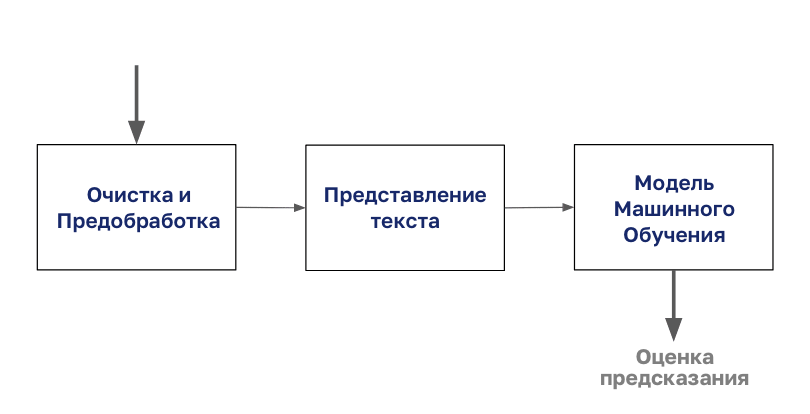

### Text preprocessing

- Допустил досадный промах с выбором библиотеки, нужно было применить pymorphy2 (которая работает в [два раза быстрее](https://habr.com/ru/post/503420/))

In [60]:
lemmatizer = Mystem()
stop_words = stopwords.words("russian")

# удаление Emoji
def rm_emoji(txt):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', txt)


# # удаление Emoticons
# def rm_emoticons(txt):
#     emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS_EMO) + u')')
    
#     return emoticon_pattern.sub(r'', txt)


# предобработка текста
def get_preprocessed_text(txt):
    txt = rm_emoji(txt)
#     txt = rm_emoticons(txt)
    tokens = lemmatizer.lemmatize(txt.lower())
    tokens = [token for token in tokens if token not in stop_words\
              and token != " " \
              and token.strip() not in punctuation]
    
    txt = " ".join(tokens)
    
    return txt

In [ ]:
preprocessed_text = pd.DataFrame()

preprocessed_text['comments'] = Parallel(n_jobs=-1)(delayed(get_preprocessed_text)(txt) for txt in tqdm(df['description']))

 36%|███▌      | 31712/87920 [26:30:00<25:43:43,  1.65s/it] 

In [ ]:
preprocessed_text.to_csv('preprocessed_text.csv', index=False)

### Featurization

[Цитата](https://habr.com/ru/company/sberdevices/blog/527576/):
>"_Наиболее эффективным на данный момент способом построения моделей естественного языка является обучение глубоких нейронных сетей на основе архитектуры «трансформер»: BERT, RoBERTa, GPT-3.
\
Эти модели универсальны и способны извлекать из текста признаки, полезные для решения множества задач текстового анализа. По этой причине их иногда называют моделями понимания естественного языка или NLU._"

- Для embendding'а воспользуемся облегченной версией BERT - [rubert-tiny](https://habr.com/ru/post/562064/)

In [ ]:
def get_emdedding(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    
    return embeddings[1].cpu().numpy()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
model.cuda()

preprocessed_text['embeddings'] = get_emdedding(preprocessed_text['comments'], model, tokenizer)

- _На выходе ожидается 312-мерный эмбеддинг (shape==(312,)), но код нужно еще оттестировать. Может я еще чего то не понял_

### Model

In [ ]:
def nlp_baseline_model():
    
    model_nlp = Sequential()
    model_nlp.add(L.Input(shape=(312,), name="seq_description"))
    model_nlp.add(L.LSTM(256, return_sequences=True))
    model_nlp.add(L.Dropout(0.5))
    model_nlp.add(L.LSTM(128,))
    model_nlp.add(L.Dropout(0.25))
    model_nlp.add(L.Dense(64, activation="relu"))
    model_nlp.add(L.Dropout(0.25))
    
    return model

In [ ]:
preprocessed_text.merge(df['price'], left_index=True, right_index=True)

train_text_data = preprocessed_text.query('price != -1').embeddings
test_text_data = preprocessed_text.query('price == -1').embeddings

In [ ]:
# Обучаем и тестируем модель
estimator = KerasRegressor(build_fn=nlp_baseline_model,
                           epoch=EPOCHS,
                           batch_size=BATCH_SIZE,
                           callbacks=CALLBACKS,
                           verbose=0)

kfold = KFold(n_splits=10, random_state=RANDOM_SEED)

results = cross_val_score(estimator, train_text_data, Y, cv=kfold, n_jobs=-1)

print("Results: %.2f (%.2f) MAPE" % (results.mean(), results.std()))

In [ ]:
# Здесь будет Best_Model с убранной "головой"

# model_nlp = Sequential()
# ...

# Multi-Input

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:

X_text_train, X_text_test, X_train, X_test, Y_train, Y_test = train_test_split(train_text_data, X, Y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
history = model.fit([X_text_train, X_train], Y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=([X_text_test, X_test], Y_test),
                    callbacks=CALLBACKS
                   )

In [ ]:
dl_predictions = model.predict([X_text_test, X_test])
print(f"MAPE: {(mape(Y_test, dl_predictions[:,0]))*100:0.2f}%")

In [ ]:
# submission
# ...

# Ensembling ML and DL

In [ ]:
ml_predictions = pd.read_csv('submission_automl.csv')

In [ ]:
blend_predict = (ml_predictions + dl_predictions[:,0]) / 2
print(f"MAPE: {(mape(Y_test, blend_predict))*100:0.2f}%")

In [ ]:
# submission
# ...